# 1. For the 3 labeled images, plot the expert labels for the presence or absence of clouds according to a
map (i.e. use the X, Y coordinates).

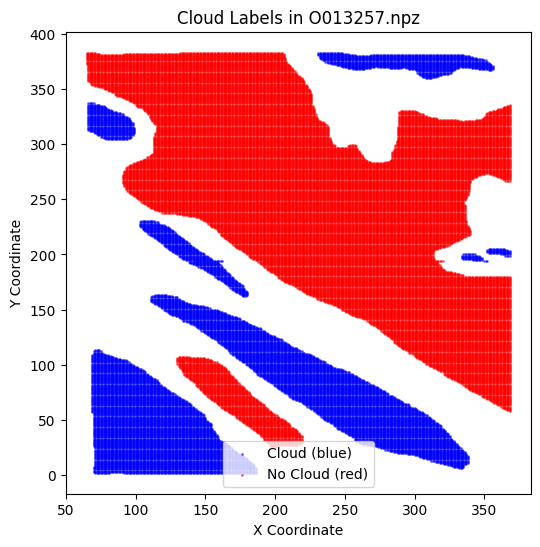

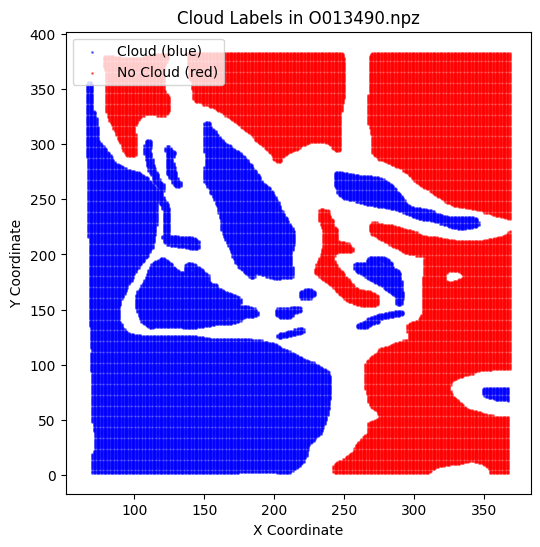

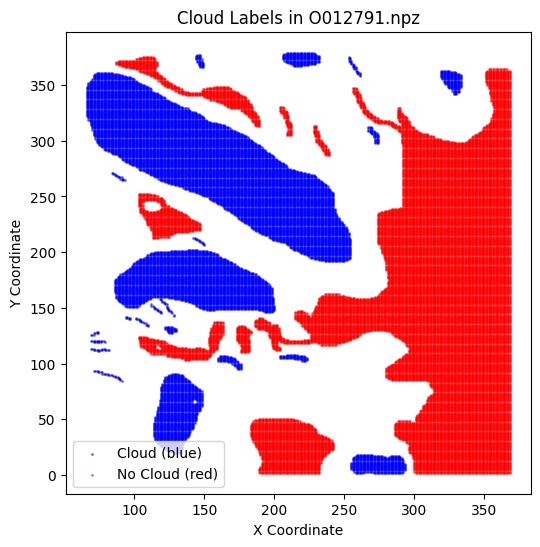

In [4]:
import numpy as np
import matplotlib.pyplot as plt

labeled_files = ["O013257.npz", "O013490.npz", "O012791.npz"]

def plot_cloud_labels(file):
    data = np.load(file)
    arr = data["arr_0"]  
   
    x, y, labels = arr[:, 1], arr[:, 0], arr[:, 10] 

    cloud_mask = labels == 1
    no_cloud_mask = labels == -1  

    plt.figure(figsize=(6, 6))
    plt.scatter(x[cloud_mask], y[cloud_mask], color='blue', label='Cloud (blue)', alpha=0.5, s=1)
    plt.scatter(x[no_cloud_mask], y[no_cloud_mask], color='red', label='No Cloud (red)', alpha=0.5, s=1)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.title(f"Cloud Labels in {file}")
    plt.show()

for file in labeled_files:
    plot_cloud_labels(file)


# 2. Explore the relationships between the radiances of different angles, both visually and quantitatively.
Do you notice differences between the two classes (cloud, no cloud) based on the radiances? Are
there differences based on the features (CORR, NDAI, SD)?

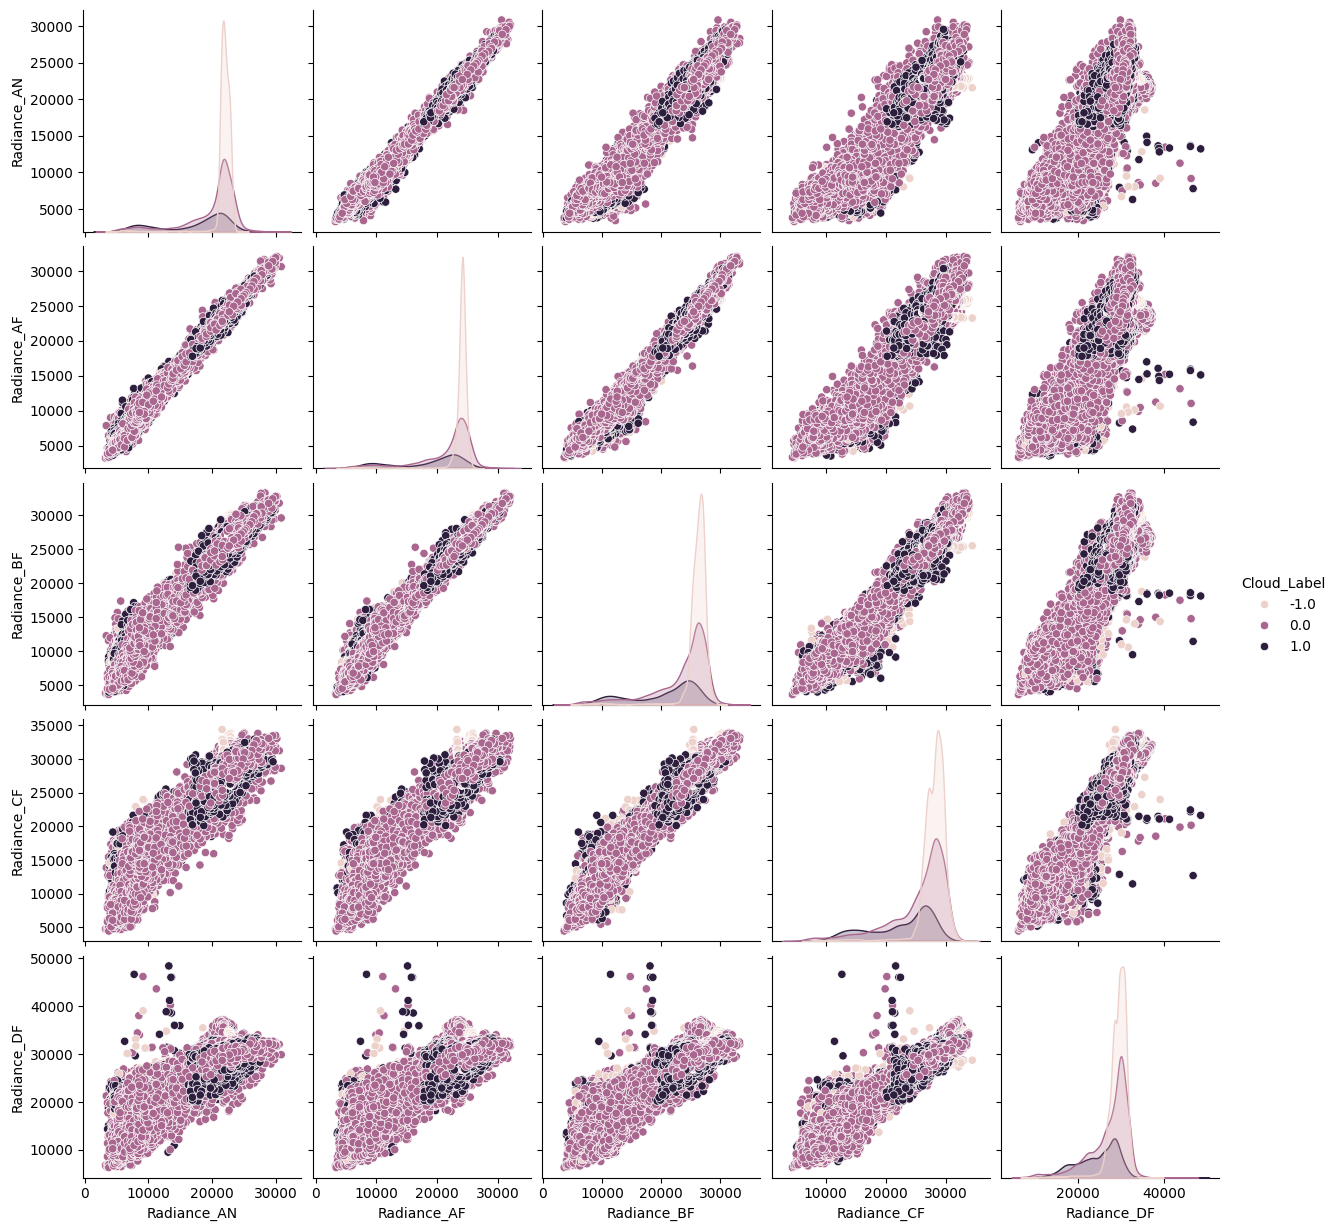

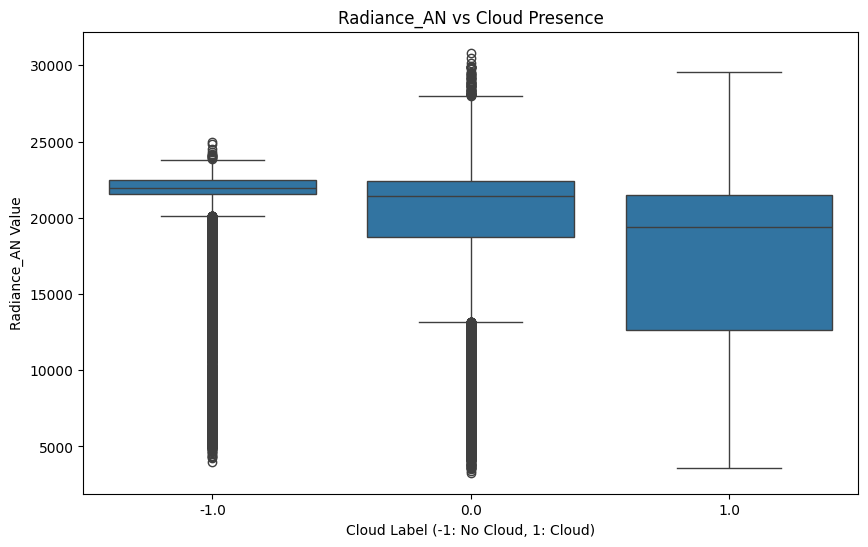

T-test: t-statistic=-110.4215, p-value=0.0000


In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind


file = "O013257.npz"  
data = np.load(file)
arr = data["arr_0"]  

df = pd.DataFrame({
    'Radiance_AN': arr[:, 9],  # Radiance AN
    'Radiance_AF': arr[:, 8],  # Radiance AF
    'Radiance_BF': arr[:, 7],  # Radiance BF
    'Radiance_CF': arr[:, 6],  # Radiance CF
    'Radiance_DF': arr[:, 5],  # Radiance DF
    'Cloud_Label': arr[:, 10] 
})


sns.pairplot(df, hue="Cloud_Label", diag_kind="kde")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df["Cloud_Label"], y=df["Radiance_AN"])
plt.title("Radiance_AN vs Cloud Presence")
plt.xlabel("Cloud Label (-1: No Cloud, 1: Cloud)")
plt.ylabel("Radiance_AN Value")
plt.show()

cloud_radiance = df[df["Cloud_Label"] == 1]["Radiance_AN"]
no_cloud_radiance = df[df["Cloud_Label"] == -1]["Radiance_AN"]

t_stat, p_value = ttest_ind(cloud_radiance, no_cloud_radiance, equal_var=False)
print(f"T-test: t-statistic={t_stat:.4f}, p-value={p_value:.4f}")


# 3. Split your data into training, validation, and test sets (or training and test, with some cross-validation scheme over the training set). Justify your choice of split based on how it reflects the challenges with possible future applications of your cloud detection algorithm.


In [10]:
from sklearn.model_selection import train_test_split

file = "O013257.npz"
data = np.load(file)
arr = data["arr_0"]

X = arr[:, 2:10]  # NDAI, SD, CORR, Radiances
y = arr[:, 10]    # Cloud Label

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"train set: {X_train.shape}, validation set: {X_val.shape}, test set: {X_test.shape}")


train set: (80500, 8), validation set: (17250, 8), test set: (17250, 8)


# 4. As is common when dealing with real world data, these images may have imperfections that you’ll need to clean up. 
Recall the skills you developed during Lab 1.

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob

directory = "/Users/jl/Downloads/image_data"
files = glob.glob(os.path.join(directory, "*.npz"))

# Initialize an empty list to collect all dataframes
all_data = []

# Loop through each file
for file in files:
    data = np.load(file)
    
    arr = data["arr_0"] 
    
    if arr.shape[1] >= 10:
        df = pd.DataFrame({
            'y_coordinate': arr[:, 0],  # y coordinate
            'x_coordinate': arr[:, 1],  # x coordinate
            'NDAI': arr[:, 2],  # NDAI
            'SD': arr[:, 3],  # SD
            'CORR': arr[:, 4],  # CORR
            'Radiance_DF': arr[:, 5],  # Radiance angle DF
            'Radiance_CF': arr[:, 6],  # Radiance angle CF
            'Radiance_BF': arr[:, 7],  # Radiance angle BF
            'Radiance_AF': arr[:, 8],  # Radiance angle AF
            'Radiance_AN': arr[:, 9],  # Radiance angle AN
        })
    else:
  
        print(f"Warning: {file} does not have enough columns (expected at least 11). Skipping file.")
        continue

    all_data.append(df)

full_df_withoutlabel = pd.concat(all_data, ignore_index=True)

print(full_df_withoutlabel.head())

missing_values = full_df_withoutlabel.isnull().sum()
print("Missing values in each column:\n", missing_values)


# Check outlier 



   y_coordinate  x_coordinate      NDAI           SD      CORR  Radiance_DF  \
0           2.0          69.0  0.611728  1231.908936 -0.489890      22497.5   
1           2.0          70.0  0.390417  1167.525391  0.013988      19543.0   
2           2.0          71.0  0.232648  1558.338867  0.063005      14891.0   
3           2.0          72.0  0.364688   838.619507 -0.122552      16829.5   
4           2.0          73.0  0.418163   555.085022 -0.401255      17152.5   

   Radiance_CF  Radiance_BF  Radiance_AF  Radiance_AN  
0     15601.00     12522.75     13800.00      5419.75  
1     16885.25     16451.75     11294.50      8568.00  
2     17842.00     17484.00      9030.75      9270.00  
3     14699.75     17251.25      9152.00      7834.75  
4     16176.50     19599.75      9025.25      7037.25  
Missing values in each column:
 y_coordinate    0
x_coordinate    0
NDAI            0
SD              0
CORR            0
Radiance_DF     0
Radiance_CF     0
Radiance_BF     0
Radiance_AF  

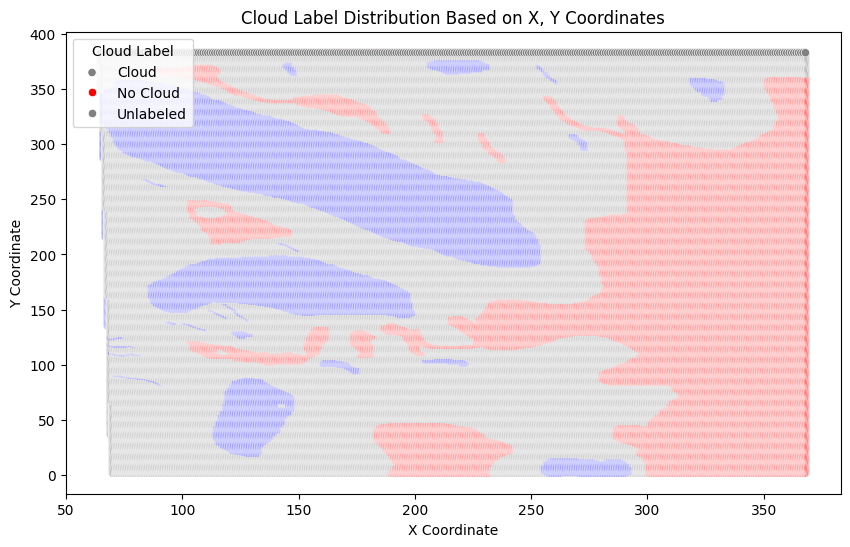

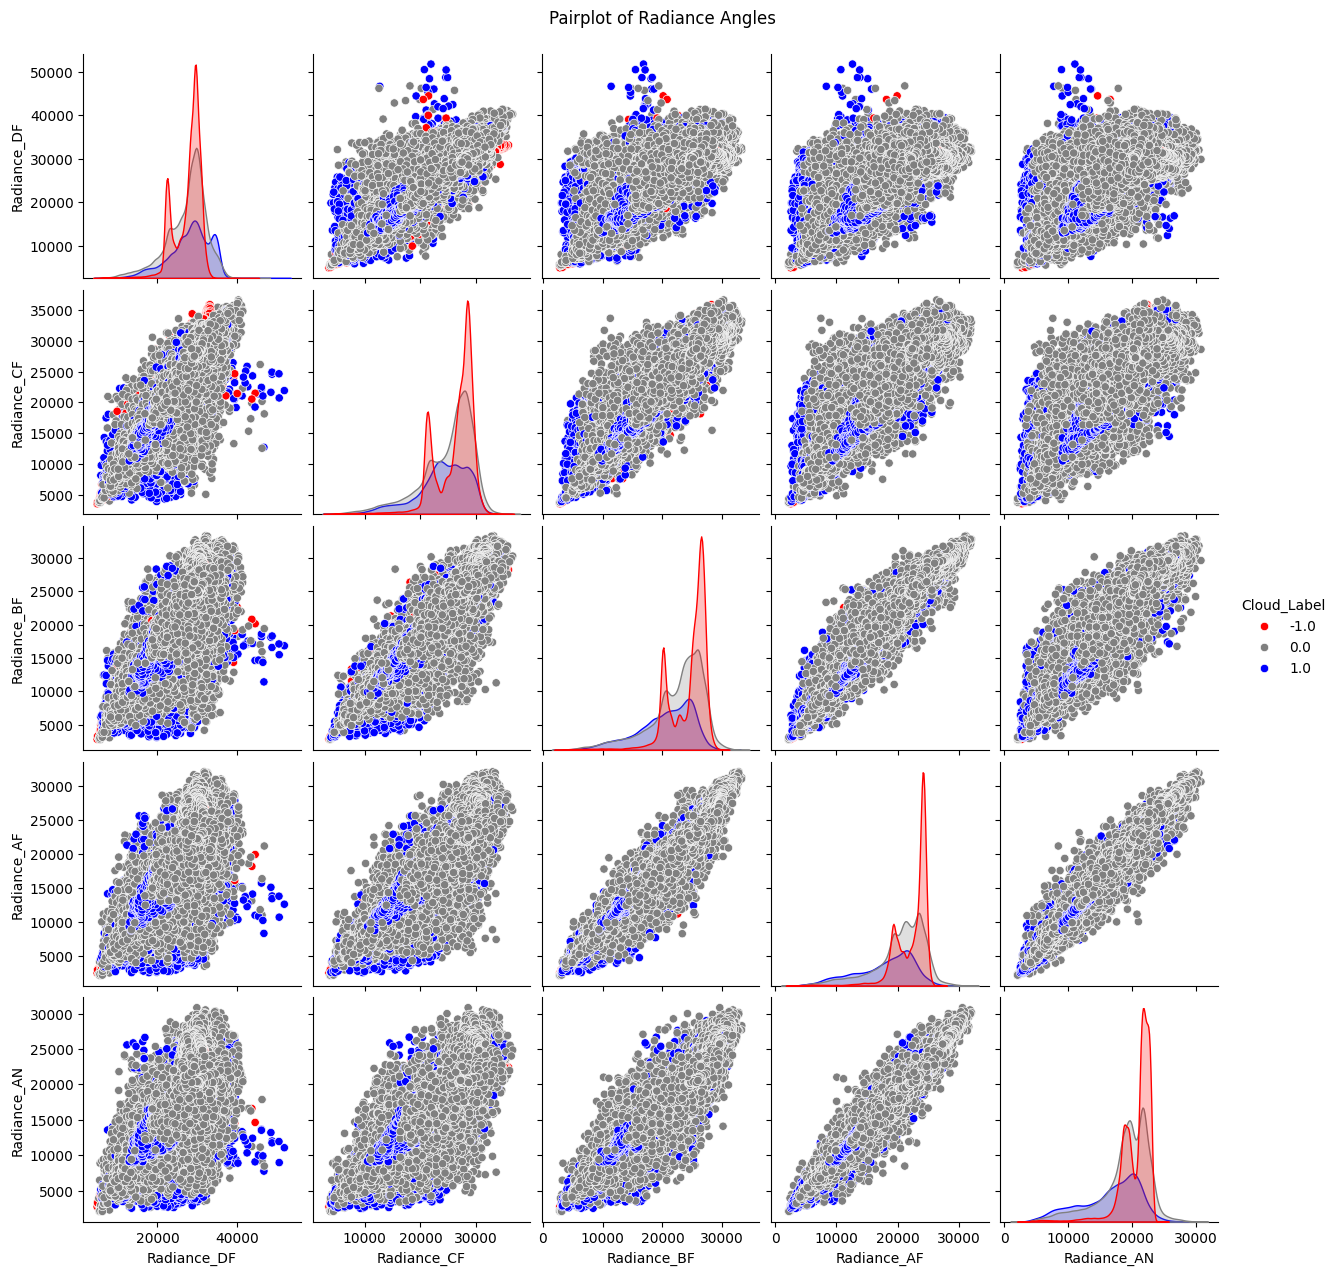

              Radiance_DF   Radiance_CF   Radiance_BF   Radiance_AF  \
Cloud_Label                                                           
-1.0         27456.423926  26099.374660  24192.799444  22200.413738   
 0.0         27320.563134  24820.762502  22393.690834  20362.074223   
 1.0         27997.866775  23911.947335  20384.505907  17869.253254   

              Radiance_AN  
Cloud_Label                
-1.0         20605.630073  
 0.0         18950.795683  
 1.0         16567.729476  
Training set size: 276004
Validation set size: 34500
Test set size: 34501
Missing values:
 y_coordinate    0
x_coordinate    0
NDAI            0
SD              0
CORR            0
Radiance_DF     0
Radiance_CF     0
Radiance_BF     0
Radiance_AF     0
Radiance_AN     0
Cloud_Label     0
dtype: int64


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

files = ["O013257.npz", "O013490.npz", "O012791.npz"]

all_data = []
for file in files:
    data = np.load(f"/Users/jl/Downloads/image_data/{file}")
    arr = data["arr_0"]  
    
    if arr.shape[1] >= 11:
        df = pd.DataFrame({
            'y_coordinate': arr[:, 0],  # y coordinate
            'x_coordinate': arr[:, 1],  # x coordinate
            'NDAI': arr[:, 2],  # NDAI
            'SD': arr[:, 3],  # SD
            'CORR': arr[:, 4],  # CORR
            'Radiance_DF': arr[:, 5],  # Radiance angle DF
            'Radiance_CF': arr[:, 6],  # Radiance angle CF
            'Radiance_BF': arr[:, 7],  # Radiance angle BF
            'Radiance_AF': arr[:, 8],  # Radiance angle AF
            'Radiance_AN': arr[:, 9],  # Radiance angle AN
            'Cloud_Label': arr[:, 10],  # Cloud presence (1: cloud, -1: no cloud)
        })
        all_data.append(df)

full_df = pd.concat(all_data, ignore_index=True)

# 1. Plotting expert labels based on X, Y coordinates
plt.figure(figsize=(10, 6))
sns.scatterplot(x='x_coordinate', y='y_coordinate', hue='Cloud_Label', data=full_df, palette={1: 'blue', -1: 'red', 0: 'gray'})
plt.title('Cloud Label Distribution Based on X, Y Coordinates')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(title="Cloud Label", loc='upper left', labels=["Cloud", "No Cloud", "Unlabeled"])
plt.show()

# 2. Exploring relationships between radiances of different angles
radiance_cols = ['Radiance_DF', 'Radiance_CF', 'Radiance_BF', 'Radiance_AF', 'Radiance_AN']
radiance_data = full_df[radiance_cols + ['Cloud_Label']]

# Plotting pairplot to visually explore relationships between radiance variables
sns.pairplot(radiance_data, hue='Cloud_Label', palette={1: 'blue', -1: 'red', 0: 'gray'})
plt.suptitle('Pairplot of Radiance Angles', y=1.02)
plt.show()

# Statistical analysis of the relationships between radiances and cloud labels
print(radiance_data.groupby('Cloud_Label').mean())

# 3. Split data into training, validation, and test sets
X = full_df[radiance_cols + ['NDAI', 'SD', 'CORR']]  # Features
y = full_df['Cloud_Label']  # Target label

# Split the data (80% training, 10% validation, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Output the shapes of the splits
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# 4. Cleaning the data
# Check for missing values
missing_values = full_df.isnull().sum()
print("Missing values:\n", missing_values)

In [41]:
from scipy.stats import ttest_ind

radiance_cols = ["Radiance_DF", "Radiance_CF", "Radiance_BF", "Radiance_AF", "Radiance_AN"]

for col in radiance_cols:
    cloud_radiance = full_df[full_df["Cloud_Label"] == 1][col]
    no_cloud_radiance = full_df[full_df["Cloud_Label"] == -1][col]
    
    t_stat, p_value = ttest_ind(cloud_radiance, no_cloud_radiance, equal_var=False)
    print(f"{col}: T-statistic={t_stat:.4f}, p-value={p_value:.4f}")


Radiance_DF: T-statistic=25.9381, p-value=0.0000
Radiance_CF: T-statistic=-112.9533, p-value=0.0000
Radiance_BF: T-statistic=-202.7150, p-value=0.0000
Radiance_AF: T-statistic=-232.2590, p-value=0.0000
Radiance_AN: T-statistic=-226.8990, p-value=0.0000
